In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('cleaned_data.csv')

In [6]:
df['order_weight'] = df['order_weight'].replace(0.0, np.nan)

In [7]:
df['order_weight'].sort_values()

216988    1.0
184585    1.0
52622     1.0
76695     1.0
123129    1.0
         ... 
232879    NaN
232955    NaN
232962    NaN
232978    NaN
233004    NaN
Name: order_weight, Length: 233016, dtype: float64

<AxesSubplot:xlabel='order_class_size', ylabel='order_weight'>

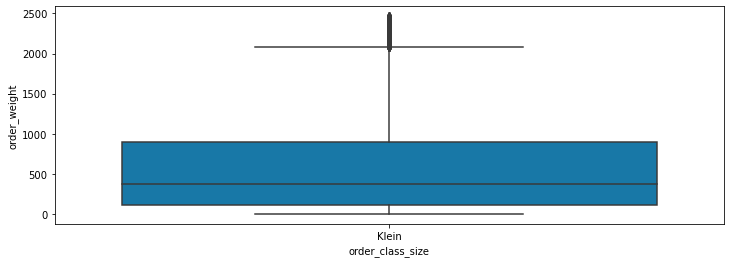

In [8]:
plt.figure(figsize=(12,4))
sns.boxplot(x='order_class_size',
           y='order_weight',
           data=df,
           palette='winter')

In [9]:
df.groupby(by='order_class_size').median()['order_weight']

order_class_size
Klein    375.0
Name: order_weight, dtype: float64

In [10]:
# show the difference between mean globally and defined by order_class_size
df['order_weight'].mean()

561.6238124015435

In [12]:
#after correcting the data with IQR, it seems that order_size_class only consist of one category. Before
#I had more, so this code is purely to demonstrate how it is possible to calc medians per category and fill them
#in the dataset
def impute_order_weight(cols):
    order_weight=cols[0]
    order_class_size=cols[1]
    
    if pd.isnull(order_weight):
        if order_class_size == 'Klein':
            return 424
        if order_class_size == 'Middel':
            return 3153
        if order_class_size == 'MiddelGroot':
            return 4953
        else:
            return 7929
    
    else:
        return order_weight

In [13]:
df_copy = df.copy()

In [14]:
df_copy['order_weight'] = df_copy[['order_weight','order_class_size']].apply(impute_order_weight, axis=1)

<AxesSubplot:>

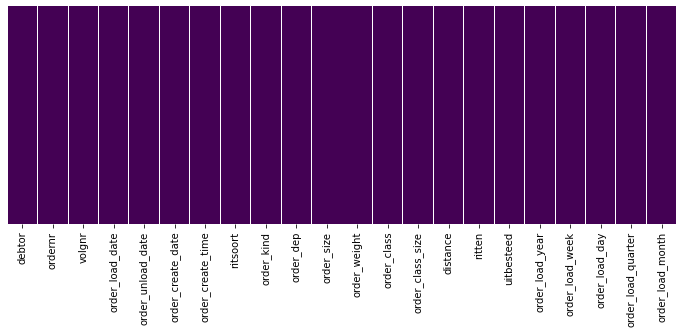

In [15]:
plt.figure(figsize=(12,4))
sns.heatmap(data=df_copy.isnull(),
           yticklabels=False,
           cbar=False,
           cmap='viridis')

In [16]:
df_copy['order_weight'].mean()

531.603209693755

In [17]:
#repeat above steps with main dataframe
df['order_weight'] = df[['order_weight','order_class_size']].apply(impute_order_weight, axis=1)

In [18]:
df['order_weight'].isnull().sum()

0

In [19]:
df[['order_load_date','order_unload_date', 'order_create_date']] = df[['order_load_date','order_unload_date', 'order_create_date']].apply(pd.to_datetime)

In [20]:
df = pd.get_dummies(data=df, columns=['ritsoort','order_kind', 'order_dep','order_class', 'order_class_size'], drop_first=True)

In [21]:
df.shape

(233016, 45)

In [22]:
df_1 = df[['order_load_date','order_size']]

In [23]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233016 entries, 0 to 233015
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   order_load_date  233016 non-null  datetime64[ns]
 1   order_size       233016 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.6 MB


In [28]:
#transform data to timeseries
df_1 = df_1.groupby(by='order_load_date').sum()

In [30]:
df_1.index

DatetimeIndex(['2018-12-31', '2019-01-02', '2019-01-03', '2019-01-04',
               '2019-01-05', '2019-01-07', '2019-01-08', '2019-01-10',
               '2019-01-11', '2019-01-14',
               ...
               '2021-09-22', '2021-09-23', '2021-09-24', '2021-09-26',
               '2021-09-27', '2021-09-28', '2021-09-29', '2021-09-30',
               '2021-10-02', '2021-10-03'],
              dtype='datetime64[ns]', name='order_load_date', length=780, freq=None)

In [33]:
#set timeseries frequientie to Day
df_1 = df_1.asfreq('D', fill_value=0)

In [34]:
df_1.index

DatetimeIndex(['2018-12-31', '2019-01-01', '2019-01-02', '2019-01-03',
               '2019-01-04', '2019-01-05', '2019-01-06', '2019-01-07',
               '2019-01-08', '2019-01-09',
               ...
               '2021-09-24', '2021-09-25', '2021-09-26', '2021-09-27',
               '2021-09-28', '2021-09-29', '2021-09-30', '2021-10-01',
               '2021-10-02', '2021-10-03'],
              dtype='datetime64[ns]', name='order_load_date', length=1008, freq='D')

<AxesSubplot:xlabel='order_load_date'>

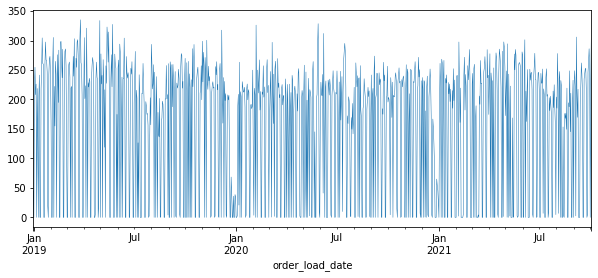

In [35]:
plt.figure(figsize=(10,4))
df_1['order_size'].plot(linewidth=0.5)

<AxesSubplot:xlabel='order_load_date'>

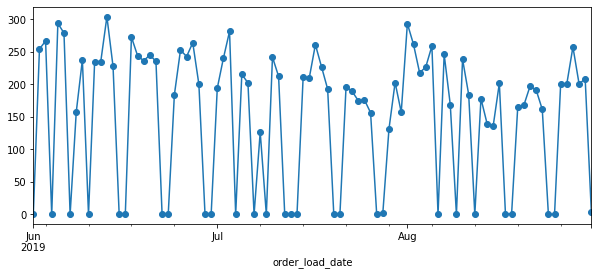

In [36]:
plt.figure(figsize=(10,4))
df_1.loc['2019-06':'2019-08', 'order_size'].plot(marker='o')
#df_1.loc['2020-06':'2020-08', 'order_size'].plot(marker='o')


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

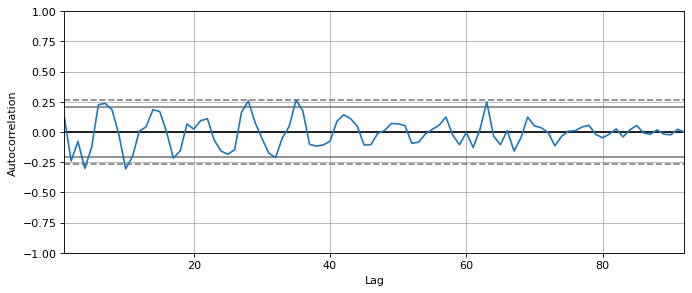

In [37]:
plt.figure(figsize=(10,4), dpi=80)
pd.plotting.autocorrelation_plot(df_1.loc['2019-06':'2019-08', 'order_size'])

In [38]:
df_1['year'] = df_1.index.isocalendar().year
df_1['week'] = df_1.index.isocalendar().week
df_1['day'] = df_1.index.isocalendar().day

In [45]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1008 entries, 2018-12-31 to 2021-10-03
Freq: D
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   order_size  1008 non-null   float64
 1   year        1008 non-null   UInt32 
 2   week        1008 non-null   UInt32 
 3   day         1008 non-null   UInt32 
dtypes: UInt32(3), float64(1)
memory usage: 62.8 KB


<AxesSubplot:xlabel='week', ylabel='order_size'>

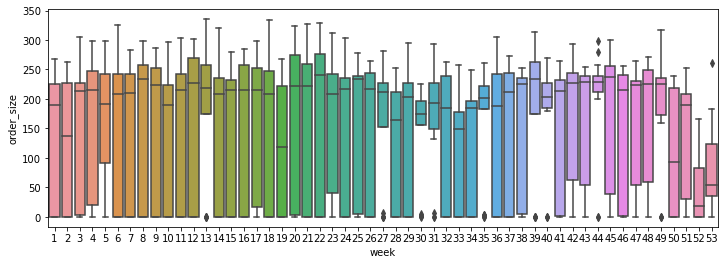

In [40]:
fig, axes = plt.subplots(figsize=(12,4), sharex=True)
sns.boxplot(data=df_1, x='week', y='order_size')

In [41]:
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [42]:
def regression_results(y_true, y_pred):
    #regression metrics
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    mean_squared_log_error = metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    
    print('explained variance :',round(explained_variance,4))
    print('mean squared log error :', round(mean_squared_log_error,4))
    print('r2 :',round(r2,4))
    print('MAE :',round(mean_absolute_error,4))
    print('MSE :',round(mse,4))
    print('RMSE :',round(np.sqrt(mse),4))
    

In [238]:
#add columns yesterday lag and difference with yesterday
#df_1['yesterday'] = df_1['order_size'].shift()
#df_1['yesterday_diff'] = df_1['yesterday'].diff()

In [240]:
#drop na
#df_1 = df_1.dropna()

In [43]:
#create train en test set 50/50
#X_train = df_1.loc[:'2019'].drop('order_size', axis=1)
#y_train = df_1.loc[:'2019', 'order_size']
#X_test = df_1.loc['2020'].drop('order_size', axis=1)
#y_test = df_1.loc['2020', 'order_size']
df_1.head().sort_values

<bound method DataFrame.sort_values of                  order_size  year  week  day
order_load_date                             
2018-12-31         45.37500  2019     1    1
2019-01-01          0.00000  2019     1    2
2019-01-02        221.35570  2019     1    3
2019-01-03        254.63450  2019     1    4
2019-01-04        208.07718  2019     1    5>

In [46]:
X = df_1.drop(['order_size'], axis=1)
y = df_1['order_size']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [453]:
#scaler = StandardScaler()

In [48]:
#scaler.fit(X_train)
#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)

In [49]:
X_train.shape

(705, 3)

In [50]:
from sklearn.model_selection import TimeSeriesSplit

In [51]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

In [52]:
models = []
models.append(('LR', LinearRegression(n_jobs=5)))
models.append(('NN', MLPRegressor(solver='lbfgs', max_iter=1000)))
models.append(('KNN', KNeighborsRegressor()))
models.append(('RF', RandomForestRegressor(n_estimators=10)))
models.append(('SVR', SVR(gamma='auto')))

In [53]:
from sklearn.model_selection import cross_val_score

In [54]:
results = []
names = []
for name, model in models:
    #timeseries crossvalidation
    tscv = TimeSeriesSplit(n_splits=5)
    
    cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2') 
    
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.158474 (0.008444)
NN: 0.158722 (0.010170)
KNN: 0.092664 (0.115335)
RF: 0.054607 (0.149511)
SVR: -0.218858 (0.085253)


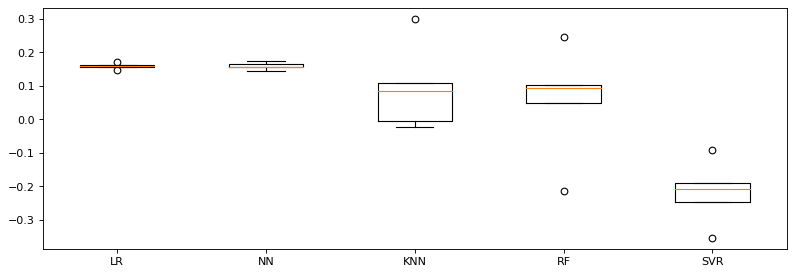

In [55]:
plt.figure(figsize=(12,4), dpi=80)
plt.boxplot(results, labels=names)
plt.show()

In [56]:
from sklearn.model_selection import GridSearchCV

In [57]:
# performing Grid Search
model = LinearRegression()
#param_search = {
#    'n_estimators': [20,50,100],
#    'max_features': ['auto', 'sqrt', 'log2'],
#    'max_depth':[i for i in range(5,15)]
#}

param_search = {
    'normalize': [True]
}

In [58]:
# Create custom scorer for the model part I
from sklearn.metrics import make_scorer

In [59]:
# Create custom scorer for the model part II
def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    
    distance = predict - actual
    
    square_distance = distance ** 2
    
    mean_square_distance = square_distance.mean()
    
    score = np.sqrt(mean_square_distance)
    
    return score

In [60]:
# Create custom scorer for the model part III
rmse_score = make_scorer(rmse, greater_is_better=False)

In [61]:
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid = param_search, 
                       scoring = rmse_score)

In [62]:
gsearch.fit(X_train, y_train)

best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

In [63]:
best_score

-100.66632153114107

In [64]:
best_model

LinearRegression(normalize=True)

In [65]:
y_true = y_test.values
y_pred = best_model.predict(X_test)

regression_results(y_true, y_pred)

explained variance : 0.2079
mean squared log error : 6.7712
r2 : 0.2069
MAE : 85.562
MSE : 9739.6755
RMSE : 98.6898


In [66]:
df_2 = df_1.copy()

In [67]:
df_2['last_week'] = df_2['order_size'].shift(7)

In [68]:
df_2['last_week_diff'] = df_2['last_week'].diff()

In [69]:
df_2 = df_2.dropna()

In [70]:
df_2.head()

,order_size,year,week,day,last_week,last_week_diff
order_load_date,,,,,,
2019-01-08,137.8065,2019,2,2,0.00000,-45.37500
2019-01-09,0.0000,2019,2,3,221.35570,221.35570
2019-01-10,206.2400,2019,2,4,254.63450,33.27880
2019-01-11,241.4170,2019,2,5,208.07718,-46.55732
2019-01-12,0.0000,2019,2,6,226.09680,18.01962


In [71]:
X_2 = df_2.drop(['order_size'], axis=1)
y_2 = df_2['order_size']

In [72]:
X_train_2, X_test, y_train_2, y_test = train_test_split(X_2, y_2, test_size=0.3, random_state=100)

In [73]:
# testing model on new features
gsearch.fit(X_train_2, y_train_2)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

In [74]:
y_true = y_test.values
y_pred = best_model.predict(X_test)

In [75]:
regression_results(y_true, y_pred)

explained variance : 0.2977
mean squared log error : 6.3153
r2 : 0.2976
MAE : 77.5665
MSE : 8625.0397
RMSE : 92.8711


In [76]:
df_2

,order_size,year,week,day,last_week,last_week_diff
order_load_date,,,,,,
2019-01-08,137.8065,2019,2,2,0.00000,-45.37500
2019-01-09,0.0000,2019,2,3,221.35570,221.35570
2019-01-10,206.2400,2019,2,4,254.63450,33.27880
2019-01-11,241.4170,2019,2,5,208.07718,-46.55732
2019-01-12,0.0000,2019,2,6,226.09680,18.01962
...,...,...,...,...,...,...
2021-09-29,286.0280,2021,39,3,251.38300,8.47150
2021-09-30,254.2270,2021,39,4,253.07300,1.69000
2021-10-01,0.0000,2021,39,5,212.84250,-40.23050


Feature: 0, Score: -2.58594
Feature: 1, Score: -0.23106
Feature: 2, Score: -20.95122
Feature: 3, Score: 0.19415
Feature: 4, Score: -0.12196


<AxesSubplot:>

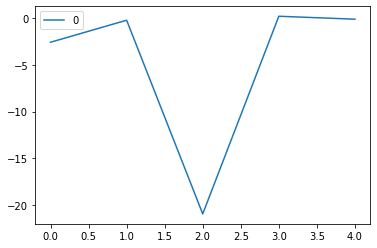

In [77]:
#variable importance plot
importance = best_model.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pd.DataFrame(importance).plot()


In [78]:
best_model.coef_

array([ -2.58594018,  -0.23106331, -20.95121536,   0.1941465 ,
        -0.12196011])

In [79]:
X_train_2

,year,week,day,last_week,last_week_diff
order_load_date,,,,,
2020-03-03,2020,10,2,250.8615,43.0405
2019-10-13,2019,41,7,0.0000,-202.5829
2019-08-14,2019,33,3,246.3090,246.3090
2020-01-06,2020,2,1,38.7550,38.7550
2021-05-07,2021,18,5,255.2650,-33.6267
...,...,...,...,...,...
2021-05-12,2021,19,3,294.4575,294.2575
2021-05-28,2021,21,5,221.2735,-53.6225
2021-04-22,2021,16,4,270.3165,-8.7260


In [80]:
df_1.to_csv('minimal_data.csv',index=False)